# Importación

In [1675]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [1676]:
# Kaggle: https://www.kaggle.com/competitions/diamonds-part-datamad0122/
# Origen: Tiffany & Co's snapshot pricelist from 2017
df_train = pd.read_csv(r'..\data\raw\train.csv',)
df_test = pd.read_csv(r'..\data\raw\test.csv')

df_base = [df_train, df_test]
df_base


[          id  carat        cut color clarity  depth  table     x     y     z  \
 0          0   0.30    Premium     D     SI2   62.4   58.0  4.31  4.28  2.68   
 1          1   1.01      Ideal     E    VVS2   62.7   56.0  6.42  6.46  4.04   
 2          2   0.72      Ideal     F     VS2   61.8   59.0  5.71  5.74  3.54   
 3          3   1.08  Very Good     G     SI2   63.2   57.0  6.54  6.50  4.12   
 4          4   0.36    Premium     G     VS1   62.3   59.0  4.50  4.55  2.82   
 ...      ...    ...        ...   ...     ...    ...    ...   ...   ...   ...   
 40450  40450   0.42    Premium     D     SI2   62.1   59.0  4.78  4.82  2.98   
 40451  40451   0.53    Premium     G     VS2   62.0   58.0  5.21  5.18  3.22   
 40452  40452   0.80       Good     G     SI2   62.8   58.0  5.86  5.90  3.69   
 40453  40453   1.01  Very Good     F     VS2   61.5   57.0  6.40  6.48  3.96   
 40454  40454   1.30    Premium     I     VS2   60.1   58.0  7.10  7.14  4.28   
 
        price  
 0      6.

# Observaciones iniciales

In [1677]:
df_base[0].head()


,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,0.30,Premium,D,SI2,62.4,58.0,4.31,4.28,2.68,6.353
1,1,1.01,Ideal,E,VVS2,62.7,56.0,6.42,6.46,4.04,9.183
2,2,0.72,Ideal,F,VS2,61.8,59.0,5.71,5.74,3.54,7.983
3,3,1.08,Very Good,G,SI2,63.2,57.0,6.54,6.50,4.12,8.371
4,4,0.36,Premium,G,VS1,62.3,59.0,4.50,4.55,2.82,6.588


In [1678]:
# Adaptamos los nombres de las columnas para que sean legibles y borramos la primera porque no sirve
for df in df_base:
    df.rename(columns={'carat': 'weight (carat)',
                        'cut': 'cut quality',
                        'color': 'color quality',
                        'clarity': 'clarity quality', # Fuente: https://4cs.gia.edu/en-us/diamond-clarity/
                        'depth': 'depth (percentage)', # Medida de la altura ("depth") del diamante en relación a su diámetro. Fuente: https://www.withclarity.com/education/diamond-education/diamond-cut/what-is-diamond-depth-or-diamond-education
                        'table': 'table (percentage)', # Medida de la parte plana ("table") del diamante en relación a su diámetro. Fuente: https://www.brilliance.com/education/diamonds/depth-table
                        'x': 'lenght (millimeters)', # Visto desde arriba, longitud de un costado del diamante. Su media con "width" da el diámetro
                        'y': 'width (millimeters)', # Visto desde arriba, longitud del otro costado
                        'z': 'depth (millimeters)' # Altura (distancia entre la punta y la parte plana)
                        }, inplace=True
                )


In [1679]:
df_base[0].head()


,id,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price
0,0,0.30,Premium,D,SI2,62.4,58.0,4.31,4.28,2.68,6.353
1,1,1.01,Ideal,E,VVS2,62.7,56.0,6.42,6.46,4.04,9.183
2,2,0.72,Ideal,F,VS2,61.8,59.0,5.71,5.74,3.54,7.983
3,3,1.08,Very Good,G,SI2,63.2,57.0,6.54,6.50,4.12,8.371
4,4,0.36,Premium,G,VS1,62.3,59.0,4.50,4.55,2.82,6.588


In [1680]:
# No hay valores nulos fuera del target
df_base[0].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    40455 non-null  int64  
 1   weight (carat)        40455 non-null  float64
 2   cut quality           40455 non-null  object 
 3   color quality         40455 non-null  object 
 4   clarity quality       40455 non-null  object 
 5   depth (percentage)    40455 non-null  float64
 6   table (percentage)    40455 non-null  float64
 7   lenght (millimeters)  40455 non-null  float64
 8   width (millimeters)   40455 non-null  float64
 9   depth (millimeters)   40455 non-null  float64
 10  price                 40455 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 3.4+ MB


In [1681]:
# No parece posible que haya diamantes con 0 milimetros de altura, anchura o profundidad. Quizá lo que ocurra es que son tan redondos que no cabe medir algunos datos. Habrá que revisarlo
df_base[0].describe()


,id,weight (carat),depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price
count,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000
mean,20227.000000,0.797576,61.746377,57.451694,5.729163,5.732896,3.537351,7.783822
std,11678.496907,0.475939,1.436796,2.234569,1.125244,1.154799,0.711002,1.016828
min,0.000000,0.200000,43.000000,44.000000,0.000000,0.000000,0.000000,5.787000
25%,10113.500000,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000,6.851000
50%,20227.000000,0.700000,61.800000,57.000000,5.690000,5.700000,3.520000,7.780000
75%,30340.500000,1.040000,62.500000,59.000000,6.540000,6.540000,4.030000,8.581000
max,40454.000000,5.010000,79.000000,95.000000,10.740000,58.900000,31.800000,9.842000


In [1682]:
df_base[0].describe(include='object')


,cut quality,color quality,clarity quality
count,40455,40455,40455
unique,5,7,8
top,Ideal,G,SI1
freq,16230,8410,9779


In [1683]:
# No hay valores duplicados
df_base[0][df_base[0].duplicated()]


,id,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price


In [1684]:
# Copiamos los "dataframes" para poder trabajar con varias versiones si conviene
df_diamonds = df_base.copy()
df_diamonds


[          id  weight (carat) cut quality color quality clarity quality  \
 0          0            0.30     Premium             D             SI2   
 1          1            1.01       Ideal             E            VVS2   
 2          2            0.72       Ideal             F             VS2   
 3          3            1.08   Very Good             G             SI2   
 4          4            0.36     Premium             G             VS1   
 ...      ...             ...         ...           ...             ...   
 40450  40450            0.42     Premium             D             SI2   
 40451  40451            0.53     Premium             G             VS2   
 40452  40452            0.80        Good             G             SI2   
 40453  40453            1.01   Very Good             F             VS2   
 40454  40454            1.30     Premium             I             VS2   
 
        depth (percentage)  table (percentage)  lenght (millimeters)  \
 0                    62.4

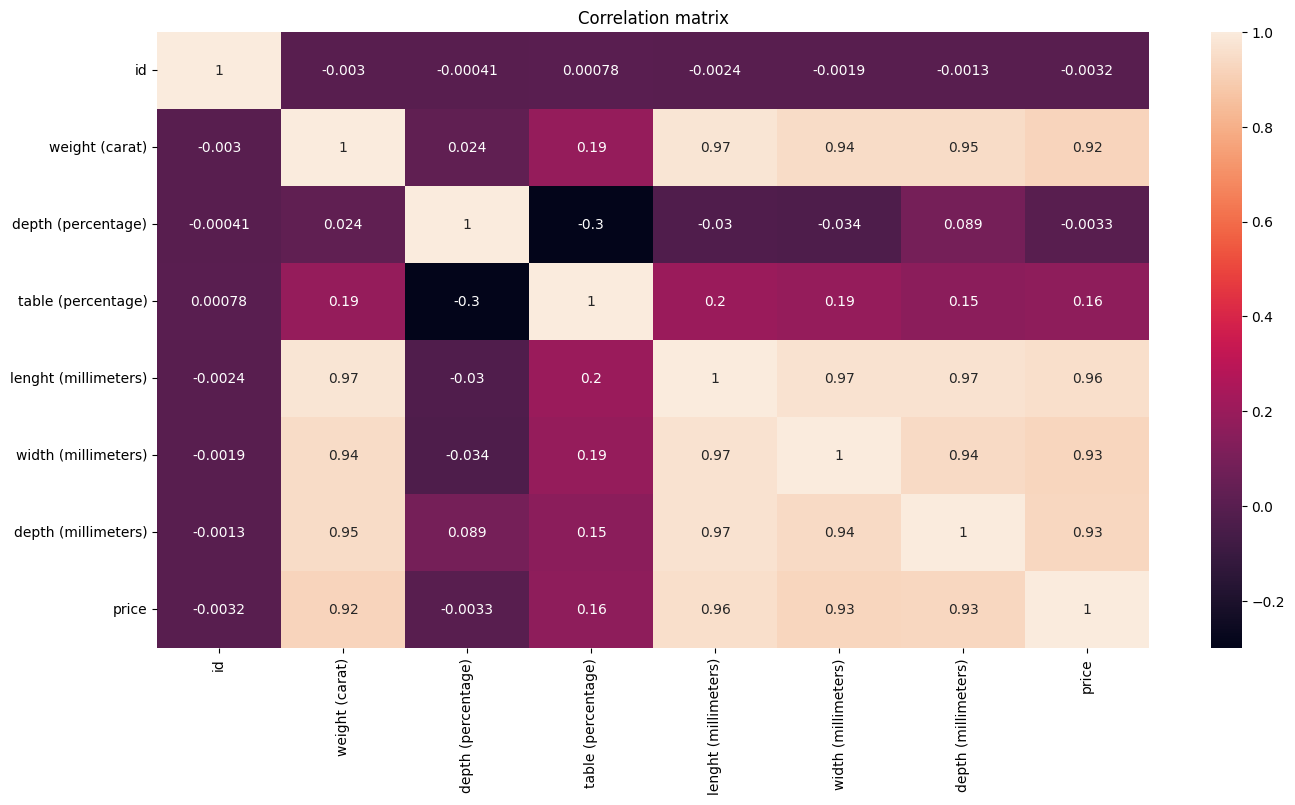

In [1685]:
# Hacemos una correlación preeliminar (sin análisis) que nos servirá para detectar errores, si los hay, durante la limpieza
plt.rc("figure", figsize=(16, 8))

corr = df_diamonds[0].corr(numeric_only=True)
sns.heatmap(corr, annot=True)
plt.title('Correlation matrix')
plt.show()


In [1686]:
# Creamos un "dataframe" que servirá para ir aplicando los cambios opcionales sin tocar el original
plt.rc("figure", figsize=(6.4, 4.8))

df_practice = df_diamonds[0].copy().drop(columns='id')

df_practice.head()


,id,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price
0,0,0.30,Premium,D,SI2,62.4,58.0,4.31,4.28,2.68,6.353
1,1,1.01,Ideal,E,VVS2,62.7,56.0,6.42,6.46,4.04,9.183
2,2,0.72,Ideal,F,VS2,61.8,59.0,5.71,5.74,3.54,7.983
3,3,1.08,Very Good,G,SI2,63.2,57.0,6.54,6.50,4.12,8.371
4,4,0.36,Premium,G,VS1,62.3,59.0,4.50,4.55,2.82,6.588


# Funciones

In [1687]:
# Estas funciones están sin detallar y no son las que se aplican al modelo definitivo
# Para ver las funciones completas homónimas con sus descripciones, mirar en la carpeta "utils"
def apply_scalar(list_of_df, method, list_of_columns=None):
    if method == 'log':
        for df in list_of_df:
            for column in list_of_columns:
                df[column] = np.log(df[column])
    elif method == 'standard':
        scaler = StandardScaler().fit(list_of_df[0].values)
        for df in list_of_df:
            df.loc[:, :] = scaler.transform(df.values)


def impute_boxplot_min_max(df, list_of_columns, min=True, max=True):
    for column in list_of_columns:
        q3, q1 = np.percentile(df[column], [75, 25])
        iqr = q3 - q1
        if min:
            df.loc[df[column] < q1 - 1.5*iqr, column] = q1 - 1.5*iqr
        if max:
            df.loc[df[column] > q3 + 1.5*iqr, column] = q3 + 1.5*iqr


def remove_elements(df, conditioned_columns, condition, number):
    for column in conditioned_columns:
        if condition == 'equal':
            df.drop(df[(df[column] == number)].index, inplace=True)
        elif condition == 'bigger':
            df.drop(df[(df[column] > number)].index, inplace=True)
        elif condition == 'bigger_or_equal':
            df.drop(df[(df[column] >= number)].index, inplace=True)   
        elif condition == 'smaller':
            df.drop(df[(df[column] < number)].index, inplace=True)   
        elif condition == 'smaller_or_equal':
            df.drop(df[(df[column] <= number)].index, inplace=True)


# Desglose por columnas

## weight (carat)

In [1688]:
df_practice['weight (carat)'].unique()


array([0.3 , 1.01, 0.72, 1.08, 0.36, 0.53, 1.74, 0.33, 0.32, 0.27, 0.63,
       0.31, 0.7 , 0.74, 1.29, 0.71, 0.52, 0.42, 1.06, 0.58, 1.5 , 1.  ,
       0.51, 1.2 , 0.41, 1.12, 1.22, 0.5 , 0.56, 2.53, 0.37, 1.7 , 0.54,
       0.34, 1.61, 0.38, 0.61, 1.21, 1.28, 1.26, 0.4 , 0.81, 0.76, 0.44,
       1.03, 0.6 , 1.1 , 0.78, 1.13, 0.77, 2.09, 0.35, 0.39, 0.9 , 1.84,
       0.79, 1.07, 1.58, 2.01, 2.  , 1.27, 1.51, 0.62, 1.68, 0.66, 1.17,
       1.56, 1.11, 0.24, 1.05, 1.65, 1.47, 2.08, 1.55, 0.55, 1.04, 1.02,
       0.43, 0.59, 0.25, 2.03, 1.25, 0.94, 1.54, 1.59, 0.26, 0.8 , 1.76,
       1.63, 1.24, 1.34, 1.52, 2.22, 0.47, 2.25, 1.39, 0.46, 0.45, 0.92,
       0.23, 1.72, 0.91, 1.53, 1.19, 0.73, 0.75, 0.29, 0.28, 1.33, 2.33,
       1.41, 1.31, 1.43, 0.93, 1.09, 1.3 , 1.73, 1.99, 1.35, 1.46, 1.71,
       1.14, 0.96, 1.15, 1.18, 1.69, 0.83, 0.57, 1.23, 2.05, 2.26, 1.6 ,
       2.12, 2.21, 2.02, 2.14, 2.06, 1.32, 1.75, 1.57, 2.74, 2.16, 2.42,
       0.97, 1.66, 1.38, 1.67, 0.65, 2.5 , 1.16, 2.

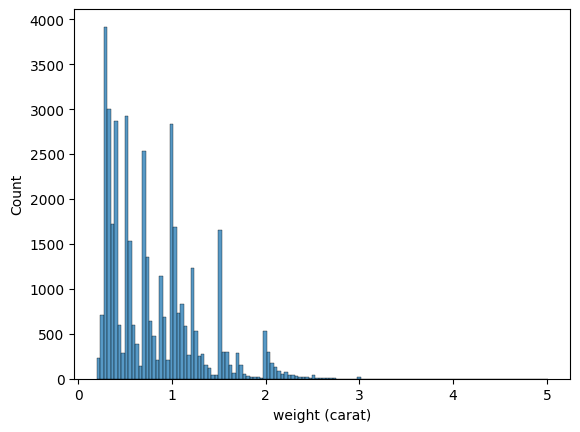

In [1689]:
# Hay muy pocos diamantes que pesen más de 2 "carat" (quilates)
sns.histplot(df_practice['weight (carat)'])
plt.show()


In [1690]:
# No hay valores que sean cero
df_practice[df_practice['weight (carat)'] == 0] 


,id,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price


### Uso del logaritmo

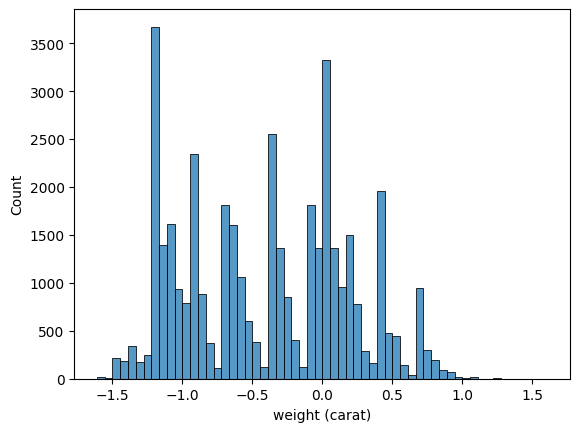

In [1691]:
# Está muy a la izquierda. Apuntamos que puede valer la pena usar el logaritmo para centrarlo, y creamos la función apply_scalar
apply_scalar([df_practice], 'log', list_of_columns=['weight (carat)'])

sns.histplot(df_practice['weight (carat)'])
plt.show()


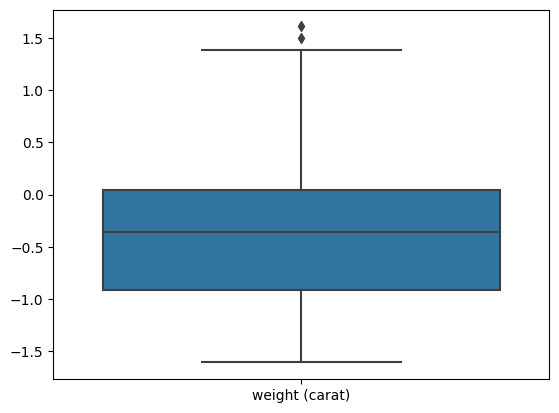

In [1692]:
# Confirmamos con un boxplot que así solo quedarían un par de valores atípicos
ax = sns.boxplot(df_practice['weight (carat)'])
ax.set_xticklabels(['weight (carat)'])
plt.show()


### Imputación a valores máximos del "boxplot"

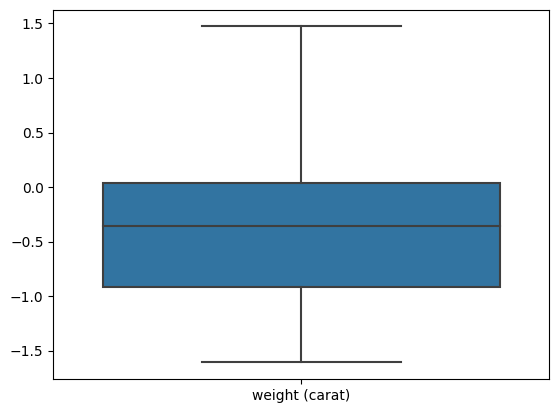

In [1693]:
# Como están cerca del máximo del boxplot, podríamos imputarlos a esa cifra. Lo apuntamos y creamos la función "impute_boxplot_min_max" en la carpeta "utils"
impute_boxplot_min_max(df_practice, ['weight (carat)'], min=False)

ax = sns.boxplot(df_practice['weight (carat)'])
ax.set_xticklabels(['weight (carat)'])
plt.show()


## cut quality

In [1694]:
# No es numérica, habrá que transformarla
for df in (df_diamonds[0], df_diamonds[1], df_practice):
    df.loc[:, 'cut quality'] = df['cut quality'].apply(lambda x: 0 if x == 'Fair' 
                                                                    else 1 if x == 'Good'
                                                                    else 2 if x == 'Very Good'
                                                                    else 3 if x == 'Premium'
                                                                    else 4
                                                        )
    df.loc[:, 'cut quality'] = df['cut quality'].astype(float)

df_practice['cut quality'].unique()


C:\Users\Roger\AppData\Local\Temp\ipykernel_14868\2601595650.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'cut quality'] = df['cut quality'].apply(lambda x: 0 if x == 'Fair'
C:\Users\Roger\AppData\Local\Temp\ipykernel_14868\2601595650.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'cut quality'] = df['cut quality'].astype(float)


array([3., 4., 2., 0., 1.])

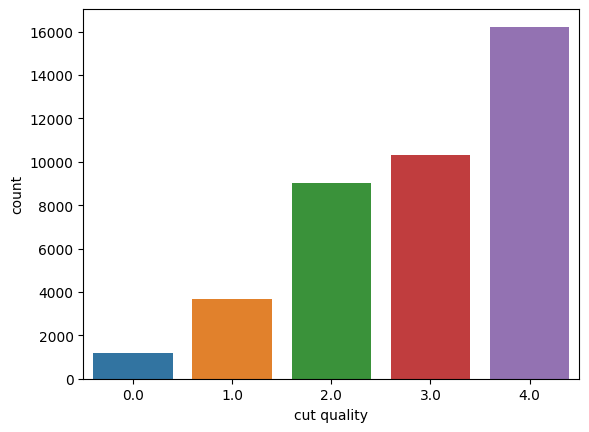

In [1695]:
# Están bastente repartidos, aunque hay menos de categoría "Good" (1) o inferior
sns.countplot(x=df_practice['cut quality'])
plt.show()


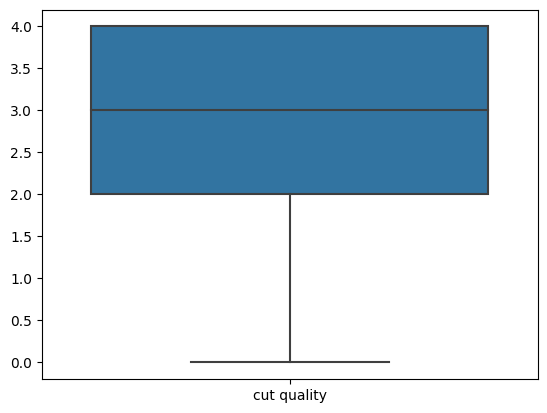

In [1696]:
# En efecto, no hay "outliers"
ax = sns.boxplot(df_practice['cut quality'])
ax.set_xticklabels(['cut quality'])
plt.show()


## color quality

In [1697]:
# Similar al anterior, hay que pasar los valores a numéricos (J es la peor calidad, y D es la mejor)
for df in df_diamonds[0], df_diamonds[1], df_practice:
    df.loc[:, 'color quality'] = df['color quality'].apply(lambda x: 0 if x == 'J' 
                                                    else 1 if x == 'I'
                                                    else 2 if x == 'H'
                                                    else 3 if x == 'G'
                                                    else 4 if x == 'F'
                                                    else 5 if x == 'E'
                                                    else 6)
    df.loc[:, 'color quality'] = df['color quality'].astype(float)

df_practice['color quality'].unique()


C:\Users\Roger\AppData\Local\Temp\ipykernel_14868\2400645494.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'color quality'] = df['color quality'].apply(lambda x: 0 if x == 'J'
C:\Users\Roger\AppData\Local\Temp\ipykernel_14868\2400645494.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'color quality'] = df['color quality'].astype(float)


array([6., 5., 4., 3., 2., 1., 0.])

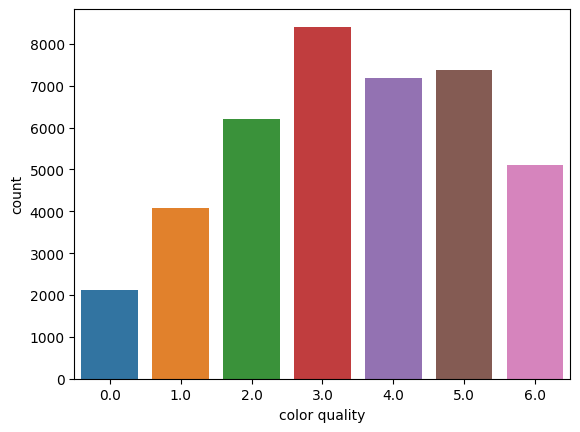

In [1698]:
# Están repartidos, si bien hay pocos de calidad J (-1.5)
sns.countplot(x=df_practice['color quality'])
plt.show()


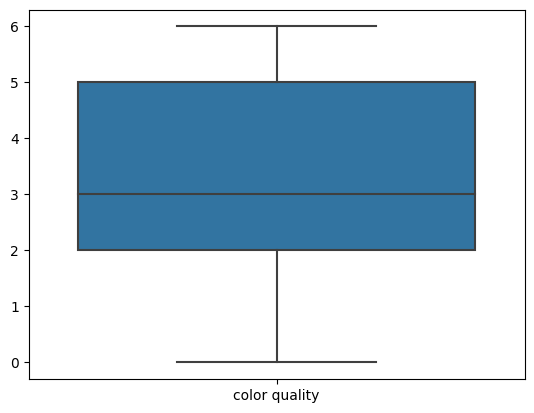

In [1699]:
# Sin valores atípicos
ax = sns.boxplot(df_practice['color quality'])
ax.set_xticklabels(['color quality'])
plt.show()


## clarity quality

In [1700]:
# Hay que buscar a qué nivel de calidad corresponde cada valor y numerarlos
df_practice['clarity quality'].unique()


array(['SI2', 'VVS2', 'VS2', 'VS1', 'SI1', 'VVS1', 'IF', 'I1'],
      dtype=object)

In [1701]:
# Fuente: https://www.77diamonds.com/es/grados-de-pureza-del-diamante
for df in (df_diamonds[0], df_diamonds[1], df_practice):
    df.loc[:, 'clarity quality'] = df['clarity quality'].apply(lambda x: 0 if x == 'I1'
                                                                else 1 if x == 'SI2'
                                                                else 2 if x == 'SI1'
                                                                else 3 if x == 'VS2'
                                                                else 4 if x == 'VS1'
                                                                else 5 if x == 'VVS2'
                                                                else 6 if x == 'VVS1'
                                                                else 7
                                                                )
    df.loc[:, 'clarity quality'] = df['clarity quality'].astype(float)

df_practice['clarity quality'].unique()


C:\Users\Roger\AppData\Local\Temp\ipykernel_14868\3318181643.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'clarity quality'] = df['clarity quality'].apply(lambda x: 0 if x == 'I1'
C:\Users\Roger\AppData\Local\Temp\ipykernel_14868\3318181643.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'clarity quality'] = df['clarity quality'].astype(float)


array([1., 5., 3., 4., 2., 6., 7., 0.])

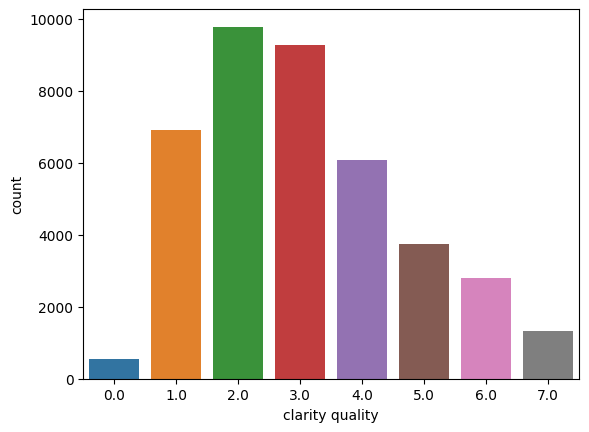

In [1702]:
# Tal como indica la fuente, los diamantes de máxima calidad son muy raros. Hay menos, todavía, de la peor calidad
sns.countplot(x=df_practice['clarity quality'])
plt.show()


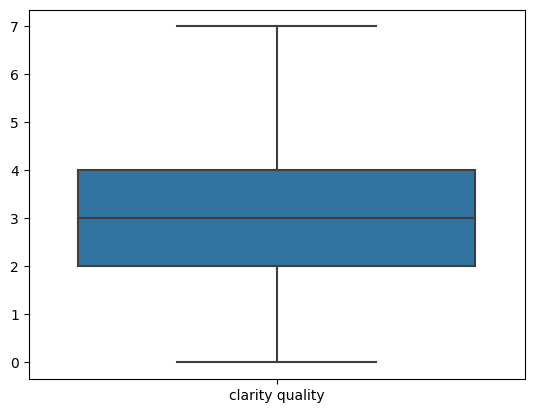

In [1703]:
# Con todo, no hay "outliers"
ax = sns.boxplot(df_practice['clarity quality'])
ax.set_xticklabels(['clarity quality'])
plt.show()


## depth (percentage)

In [1704]:
df_practice['depth (percentage)'].unique()


array([62.4, 62.7, 61.8, 63.2, 62.3, 61.4, 62.1, 60. , 62.9, 61.1, 62. ,
       62.2, 62.8, 61.6, 59.3, 61.7, 56.7, 65.3, 58.2, 61.9, 60.9, 61.5,
       63.4, 63.1, 64.9, 61.3, 63. , 60.6, 61.2, 59. , 62.5, 59.8, 63.3,
       61. , 63.9, 62.6, 57.2, 63.5, 60.7, 59.7, 59.1, 58.5, 58.4, 58.9,
       60.4, 59.9, 60.8, 59.2, 60.5, 60.2, 64.1, 63.6, 66.7, 59.6, 58. ,
       66.6, 58.7, 65.5, 57.7, 60.1, 64.6, 66.3, 64.2, 63.8, 58.1, 55.1,
       67.1, 64.3, 65.8, 58.8, 67. , 63.7, 59.5, 64. , 64.7, 67.4, 66.1,
       57.4, 59.4, 58.6, 60.3, 58.3, 57.3, 65. , 65.2, 64.4, 57.6, 57.8,
       65.4, 65.7, 66.4, 67.6, 64.8, 53.2, 64.5, 65.9, 65.1, 66.9, 69. ,
       66.5, 56.3, 67.2, 65.6, 68.5, 55.2, 57.9, 56.1, 56.9, 55.3, 56.5,
       55.9, 57.1, 69.7, 56.8, 57.5, 57. , 66. , 66.2, 71.8, 68.2, 55.8,
       66.8, 67.7, 68.1, 72.9, 67.8, 68.3, 68.6, 53.3, 67.3, 51. , 68. ,
       56.4, 55.5, 71. , 68.4, 53. , 56. , 54.2, 69.4, 53.8, 67.5, 56.2,
       69.2, 55.4, 70.2, 69.9, 68.8, 56.6, 72.2, 68

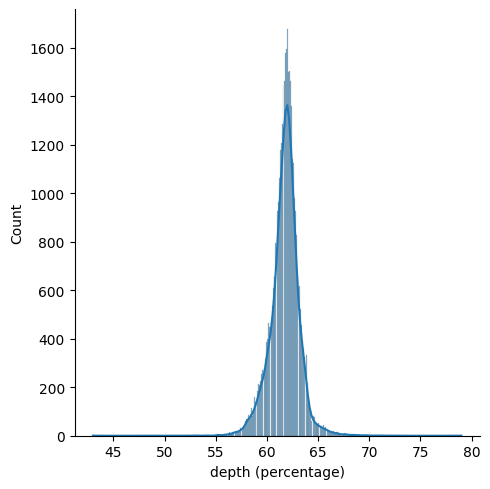

In [1705]:
# Si no fuera porque el grueso de los números se encuentra en el centro, se asemejaría bastante a una distribución normal
sns.displot(df_practice['depth (percentage)'], kde=True)
plt.show()


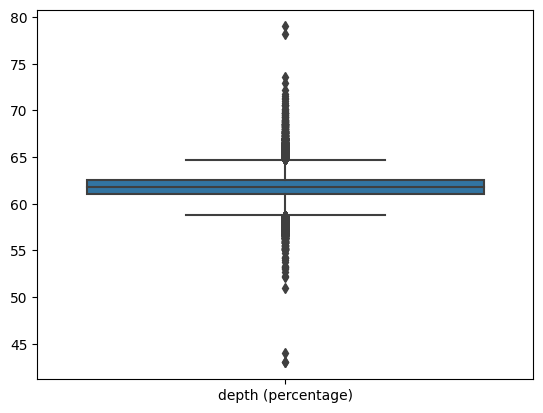

In [1706]:
# A consecuencia de ello, hay muchos "outliers". Se nota la concentración en el centro
# Hay cuatro "outliers" exageradamente altos que cabría eliminar. 
ax = sns.boxplot(df_practice['depth (percentage)'])
ax.set_xticklabels(['depth (percentage)'])
plt.show()


### Borrado de "outliers" extremadamente altos

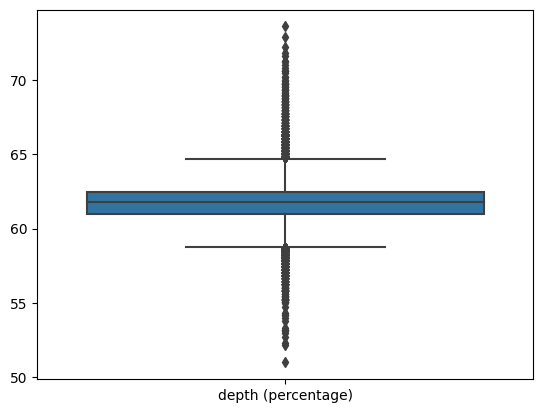

In [1707]:
# Cabría liquidar esos pocos "outliers" tremendamente altos. Creamos la función "remove_elements" para poder hacerlo si es necesario
for size in (['bigger', 75], ['smaller', 45]):
    remove_elements(df_practice, ['depth (percentage)'], size[0], size[1])

ax = sns.boxplot(df_practice['depth (percentage)'])
ax.set_xticklabels(['depth (percentage)'])
plt.show()


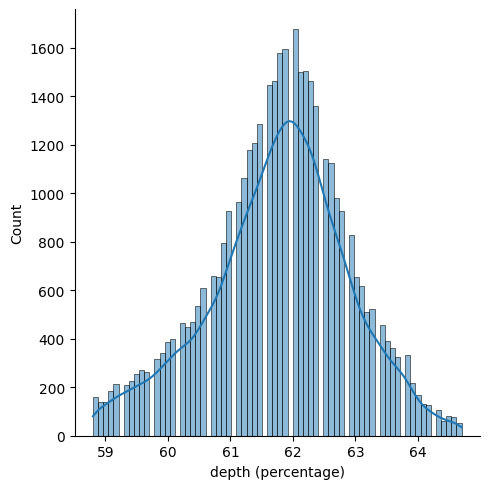

In [1708]:
# Repetimos la gráfica de densidad, pero, esta vez, filtramos los valores atípicos para una mejor visualización
# La forma recuerda a una normal, pero hay muchos valores minúsculos
q3, q1 = np.percentile(df_practice['depth (percentage)'], [75, 25])
iqr = q3 - q1

df_depth_filtered = df_practice[(df_practice['depth (percentage)'] <= q3 + 1.5*iqr) & (df_practice['depth (percentage)'] >= q1 - 1.5*iqr)]

sns.displot(df_depth_filtered['depth (percentage)'], kde=True)
plt.show()


### NO EN PRUEBA: Sustitución de valores existentes por valores calculados

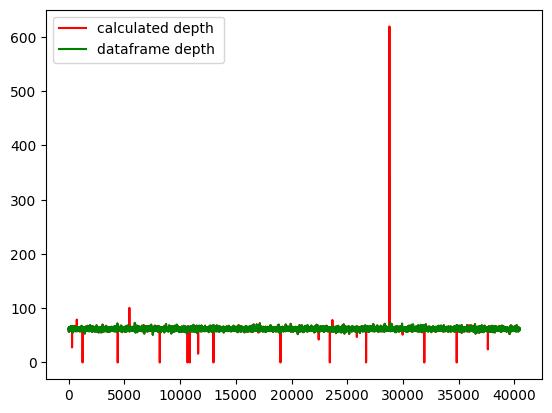

In [1709]:
# Según el autor del "dataset" en Kaggle, la variable "depth (percentage)" sale de dividir "depth (millimeters)" por la media de "lenght (millimeters)" y "width (millimeters)"
# Por tanto, si hacemos la operación, el resultado debería coincidir con la columna de "depth (percentage)"
# Notamos que no coinciden, y que la versión incluida en el "dataset" parece no tener en cuenta varios valores que se considerarían my atípicos
# Para futuras pruebas de modelo, quizá convendrá tener en cuenta los valores calculados en lugar de los que vienen dados por defecto
# Sin embargo, como nos daría nuevos "outliers", no lo aplicaremos en el "dataframe" de pruebas
calculated_depth = (df_practice['depth (millimeters)'] / ((df_practice['lenght (millimeters)']+df_practice['width (millimeters)']) / 2)) * 100
depth_comparison = pd.DataFrame({'calculated depth ': calculated_depth, 'dataframe depth': df_practice['depth (percentage)']})

depth_comparison.plot(kind='line', color=['red', 'green'])
plt.show()


## table (percentage)

In [1710]:
df_practice['table (percentage)'].unique()


array([58. , 56. , 59. , 57. , 55. , 62. , 53. , 63. , 61. , 54. , 60. ,
       64. , 65. , 55.1, 58.1, 53.6, 66. , 57.9, 68. , 56.5, 55.5, 56.6,
       55.6, 54.7, 54.8, 53.7, 54.1, 56.4, 51.6, 52. , 54.5, 57.2, 69. ,
       54.6, 54.2, 56.1, 55.9, 55.4, 59.7, 57.6, 67. , 59.9, 53.4, 60.1,
       58.2, 57.5, 53.8, 54.9, 57.8, 60.5, 56.3, 58.4, 60.3, 57.7, 60.7,
       53.5, 57.1, 61.2, 55.2, 53.9, 54.4, 56.9, 59.8, 58.6, 57.4, 59.2,
       70. , 62.4, 61.5, 55.7, 52.8, 56.8, 53.2, 61.6, 51. , 62.3, 60.2,
       49. , 57.3, 59.1, 62.5, 59.4, 55.8, 56.7, 71. , 56.2, 60.6, 55.3,
       54.3, 62.2, 62.8, 53.3, 59.5, 50.1, 59.6, 58.8, 63.4, 61.7, 65.4,
       76. , 44. , 60.4, 60.9, 61.9, 79. , 58.5, 58.9, 61.4, 50. , 61.3,
       58.3, 62.6, 53.1, 63.5, 60.8, 63.3, 61.1, 64.3, 95. , 73. , 59.3,
       58.7])

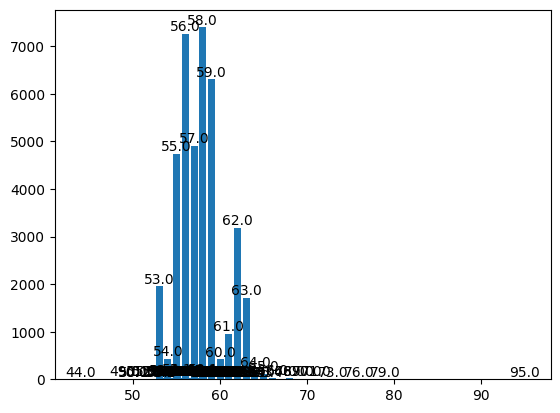

In [1711]:
# Vemos que la inmensa mayoría se encuentran entre 50% y 65%, con números distintos, y que hay unos pocos valores que se repiten mucho
# Detectamos también un "outlier" flagrante del 95%
barplot = plt.bar(x=df_practice['table (percentage)'].unique(), height=df_practice['table (percentage)'].value_counts())
plt.bar_label(barplot, labels=df_practice['table (percentage)'].unique(), label_type='edge')
plt.show()


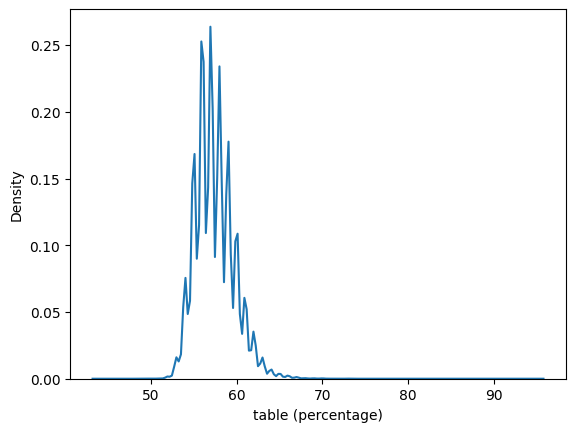

In [1712]:
# Visualizamos su gráfica de densidad para ver la tendencia general
sns.kdeplot(df_practice['table (percentage)'])
plt.show()


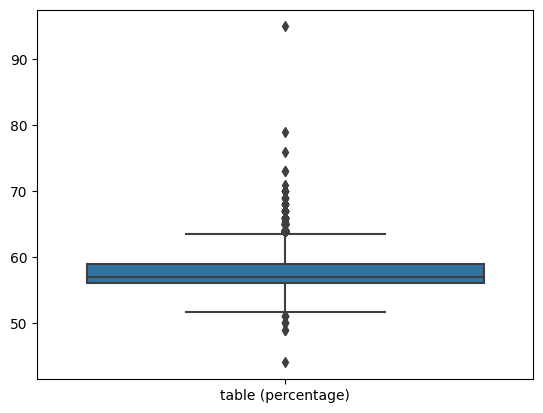

In [1713]:
# Como es de preveer hay muchos "outliers", sobre todo por la parte superior, y una concentración importante entre 55% y 60%
ax = sns.boxplot(df_practice['table (percentage)'])
ax.set_xticklabels(['table (percentage)'])
plt.show()


### Borrado de "outliers" extremadamente altos

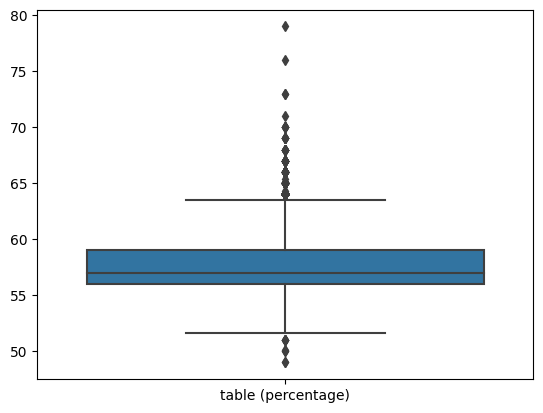

In [1714]:
# Hay un par o tres valores muy altos o bajos. Quizá nos podamos permitir eliminarlos con la función "remove_elements"
for size in (['bigger', 90], ['smaller', 45]):
    remove_elements(df_practice, ['table (percentage)'], size[0], size[1])

ax = sns.boxplot(df_practice['table (percentage)'])
ax.set_xticklabels(['table (percentage)'])
plt.show()


## price (dollars) - target

In [1715]:
# Esta es la columna "target"
df_practice['price'].unique()


array([6.353, 9.183, 7.983, ..., 7.153, 7.674, 5.852])

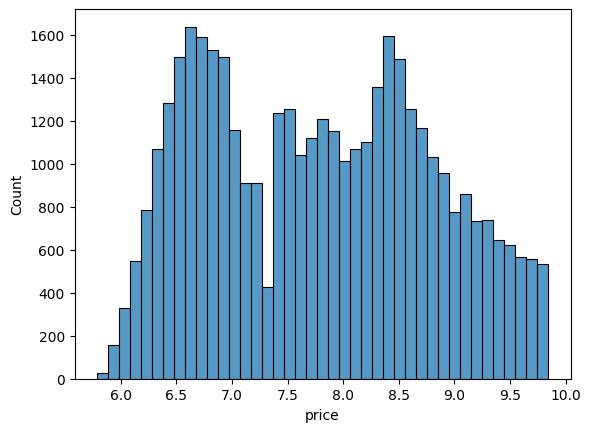

In [1716]:
# Hay muchos diamantes con un precio "asequible", y cada vez menos a medida que se encarece
sns.histplot(df_practice['price'])
plt.show()


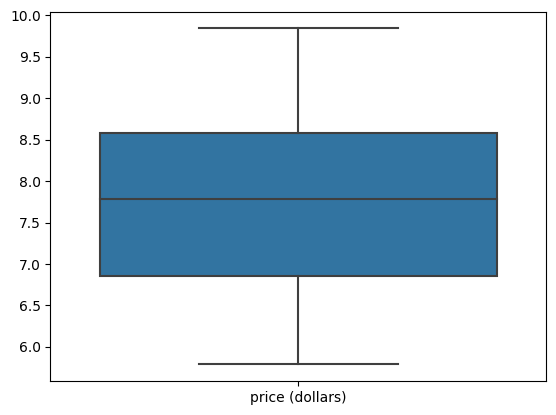

In [1717]:
# No tiene valores atípicos. Al parecer, los precios ya vienen escalados para la competición
# Esto se puede comprobar echando un vistazo al "dataset" original de Kaggle: https://www.kaggle.com/datasets/shivam2503/diamonds
ax = sns.boxplot(df_practice['price'])
ax.set_xticklabels(['price (dollars)'])
plt.show()


## lenght (millimeters)

In [1718]:
df_practice['lenght (millimeters)'].unique()


array([ 4.31,  6.42,  5.71,  6.54,  4.5 ,  5.18,  7.69,  4.53,  4.36,
        4.16,  5.52,  4.34,  5.2 ,  5.67,  6.89,  4.38,  4.9 ,  5.38,
        7.52,  4.33,  6.28,  5.15,  7.04,  4.78,  4.84,  6.74,  6.86,
        5.06,  5.33,  4.42,  5.77,  4.3 ,  4.44,  8.82,  6.24,  4.64,
        7.59,  4.39,  5.14,  4.52,  6.82,  5.68,  7.68,  5.69,  5.24,
        6.38,  4.32,  6.3 ,  4.61,  4.8 ,  5.84,  5.66,  5.48,  6.84,
        6.96,  6.88,  4.72,  4.29,  5.94,  5.1 ,  4.93,  5.8 ,  6.46,
        5.64,  6.59,  5.82,  6.87,  5.9 ,  5.12,  8.51,  4.55,  7.  ,
        4.45,  5.07,  5.73,  4.56,  4.37,  5.25,  4.66,  6.64,  6.97,
        6.58,  7.29,  4.69,  6.34,  6.18,  8.01,  6.08,  7.46,  6.79,
        4.4 ,  4.35,  6.8 ,  5.6 ,  6.57,  5.01,  5.3 ,  4.87,  6.6 ,
        5.22,  6.11,  5.46,  7.02,  4.77,  4.49,  6.51,  7.55,  8.27,
        8.09,  6.94,  7.2 ,  5.16,  7.4 ,  5.51,  7.83,  5.21,  5.11,
        6.37,  6.15,  7.32,  6.72,  7.28,  6.14,  5.76,  7.39,  5.19,
        5.61,  6.62,

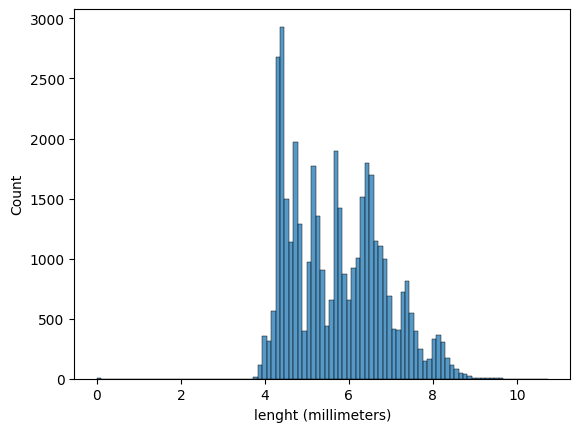

In [1719]:
# Hay muchos valores únicos, así que usamos un histograma
# Claramente ese valor cercano a cero es un "outlier"
# Hay, además, unos pocos valores muy altos, cercanos a 10
sns.histplot(df_practice['lenght (millimeters)'])
plt.show()


In [1720]:
# Si miramos esos ceros, vemos que, salvo uno, tampoco tienen width ni depth
df_practice[df_practice['lenght (millimeters)'] == 0]


,id,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price
3185,3185,0.182322,3.0,6.0,6.0,62.1,59.0,0.0,0.00,0.0,9.661
4057,4057,-0.342490,1.0,4.0,1.0,64.1,60.0,0.0,0.00,0.0,7.664
7910,7910,0.000000,2.0,2.0,3.0,63.3,53.0,0.0,0.00,0.0,8.545
8820,8820,0.810930,3.0,2.0,1.0,62.8,59.0,0.0,0.00,0.0,9.800
13711,13711,0.444686,4.0,3.0,3.0,62.2,54.0,0.0,0.00,0.0,9.457
30214,30214,-0.342490,1.0,4.0,1.0,64.1,60.0,0.0,0.00,0.0,7.664
34815,34815,0.067659,4.0,4.0,1.0,61.6,56.0,0.0,6.62,0.0,8.508


### Borrado de filas con 0 en las variables de milimetros para "lenght", "width" y "depth"

In [1721]:
# Como esas tres variables son probablemente las que más influyen en el precio, quizá cabe liquidarlos. Lo apuntamos
df_practice = df_practice.drop(df_practice[(df_practice['lenght (millimeters)'] == 0) 
                                            & (df_practice['width (millimeters)'] == 0)
                                            & (df_practice['depth (millimeters)'] == 0)
                                            ].index
                                    )

df_practice[df_practice['lenght (millimeters)'] == 0]


,id,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price
34815,34815,0.067659,4.0,4.0,1.0,61.6,56.0,0.0,6.62,0.0,8.508


In [1722]:
# Hay dos del "test" donde solo falta el depth, y uno donde faltan todos. Como están en el "test", no conviene tocarlos
df_diamonds[1][df_diamonds[1]['depth (millimeters)'] == 0]


,id,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters)
8786,8786,1.14,0.0,3.0,4.0,57.5,67.0,0.00,0.00,0.0
8876,8876,1.15,4.0,3.0,3.0,59.2,56.0,6.88,6.83,0.0
10219,10219,1.00,3.0,3.0,1.0,59.1,59.0,6.55,6.48,0.0


In [1723]:
# En cuanto al restante del de práctica, comprobamos la relación entre las columnas "lenght" y "width"
# Como los diamantes son más o menos circulares, a priori, los números de "lenght" y "width" son bastante similares
# Fuente: https://www.diamondonnet.com/knowledges/help?sword=Length%20To%20Width%20Ratio
df_practice[['lenght (millimeters)','width (millimeters)']].head()


,lenght (millimeters),width (millimeters)
0,4.31,4.28
1,6.42,6.46
2,5.71,5.74
3,6.54,6.50
4,4.50,4.55


In [1724]:
# Tanto es así que, excluyendo ese cero y redondeados, son exactamente iguales todos
all(df_practice['lenght (millimeters)'].drop(34815).apply(lambda x: round(x))) == all(df_practice['width (millimeters)'].drop(34815).apply(lambda x: round(x)))


True

### Asignación de "lenght" a partir del "width" (valor 0)

In [1725]:
# Suponemos, pues, que para ese diamante con cero son el mismo
# Por tanto, cabría asignar a ese cero la cifra correspondiente de la columna "width"
# Quedaría el "depth" de 0, pero lo revisaremos más adelante
df_practice.loc[df_practice.index == 34815, 'lenght (millimeters)'] = 6.62

df_practice['lenght (millimeters)'].head()


0    4.31
1    6.42
2    5.71
3    6.54
4    4.50
Name: lenght (millimeters), dtype: float64

### Uso del logaritmo

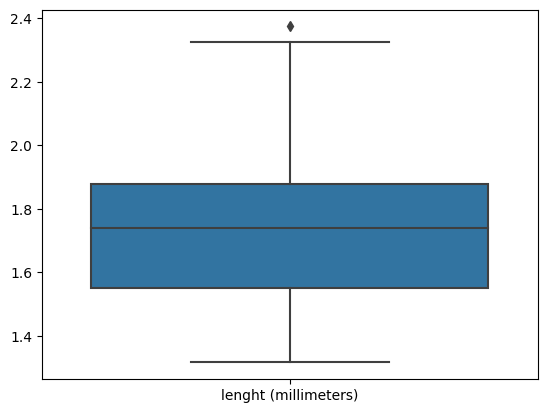

In [1726]:
# Seguidamente, podríamos aplicar el logaritmo
# Comprobamos que no quedarían "outliers" por debajo de la mediana, y que habría uno solo por encima
apply_scalar([df_practice], 'log', list_of_columns=['lenght (millimeters)'])

ax = sns.boxplot(df_practice['lenght (millimeters)'])
ax.set_xticklabels(['lenght (millimeters)'])
plt.show()


In [1727]:
# El valor atípico sería este
q3, q1 = np.percentile(df_practice['lenght (millimeters)'], [75, 25])
iqr = q3 - q1

df_practice[df_practice['lenght (millimeters)'] > q3 + 1.5*iqr]


,id,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price
6403,6403,1.472488,0.0,0.0,0.0,65.5,59.0,2.373975,10.54,6.98,9.799


### Asignación de "lenght" a partir del "width" ("outlier")

In [1728]:
# Como sabemos, por lo general, al tratarse de diamantes prácticamente circulares, el "lenght" y el "width" suelen ser muy parecidos
# Por tanto, imputaríamos ese valor atípico de "lenght" al "width" correspondiente para librarnos de él
q3, q1 = np.percentile(df_practice['lenght (millimeters)'], [75, 25])
iqr = q3 - q1

df_practice.loc[df_practice['lenght (millimeters)'] > q3 + 1.5*iqr, 'lenght (millimeters)'] = np.log(10.54)

df_practice[df_practice['lenght (millimeters)'] > q3 + 1.5*iqr]


,id,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price


## width (millimeters)

In [1729]:
df_practice['width (millimeters)'].unique()


array([ 4.28,  6.46,  5.74,  6.5 ,  4.55,  5.2 ,  7.63,  4.56,  4.39,
        4.12,  5.58,  4.37,  5.15,  5.72,  5.76,  6.93,  4.41,  5.22,
        4.92,  5.4 ,  7.57,  4.35,  6.25,  5.17,  6.95,  4.75,  4.8 ,
        6.66,  6.8 ,  4.31,  5.28,  4.46,  5.81,  6.51,  4.32,  4.45,
        8.76,  6.31,  4.6 ,  7.64,  4.34,  5.1 ,  4.57,  6.87,  5.75,
        6.83,  7.6 ,  5.73,  5.26,  6.35,  4.29,  6.38,  4.67,  4.77,
        5.8 ,  5.53,  6.9 ,  6.84,  4.66,  5.98,  4.38,  5.13,  5.87,
        4.88,  5.82,  6.43,  5.37,  5.67,  6.67,  5.7 ,  6.79,  5.85,
        5.08,  8.46,  4.52,  6.98,  4.43,  5.11,  4.27,  4.5 ,  5.23,
        4.69,  6.61,  7.01,  6.55,  7.19,  4.73,  6.44,  6.11,  7.98,
        6.06,  6.68,  4.4 ,  6.75,  5.63,  6.53,  4.48,  4.74,  5.07,
        5.12,  5.33,  4.84,  6.58,  6.02,  5.49,  6.96,  4.81,  7.5 ,
        8.2 ,  8.12,  7.16,  7.37,  5.46,  7.72,  5.24,  6.34,  6.99,
        5.14,  4.44,  5.38,  6.19,  7.27,  6.77,  7.32,  6.2 ,  7.46,
        5.65,  6.85,

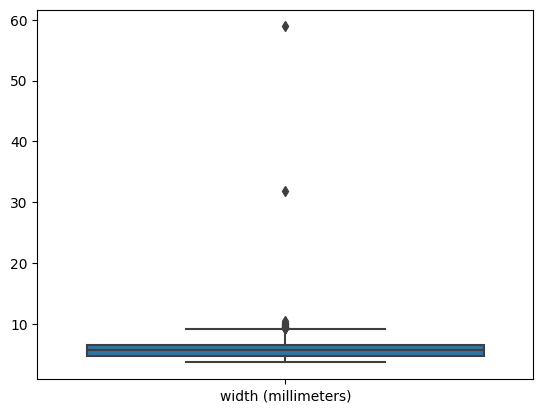

In [1730]:
# En este caso están extremadamente concentrados, si bien hay unos pocos valores, poquísimos, superiores a 10
ax = sns.boxplot(df_practice['width (millimeters)'])
ax.set_xticklabels(['width (millimeters)'])
plt.show()


### Borrado de "outliers" extremadamente altos

In [1731]:
# Hay dos valores exageradamente altos. Los borraríamos. Con los que habríamos eliminado antes en "lenght", ya no quedarían ceros tampoco en "width"
remove_elements(df_practice, ['width (millimeters)'], 'bigger', 30)

df_practice[df_practice['width (millimeters)'] == 0]


,id,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price


### Uso del logaritmo

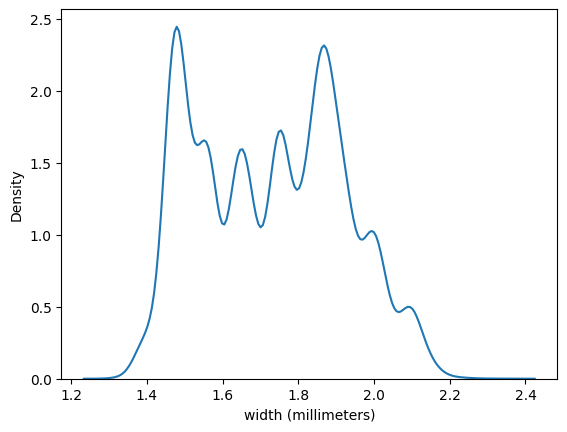

In [1732]:
# Asimismo, podríamos aplicar el logaritmo para desplazar la distribución y reducir los números
apply_scalar([df_practice], 'log', list_of_columns=['width (millimeters)'])

sns.kdeplot(df_practice['width (millimeters)'])
plt.show()


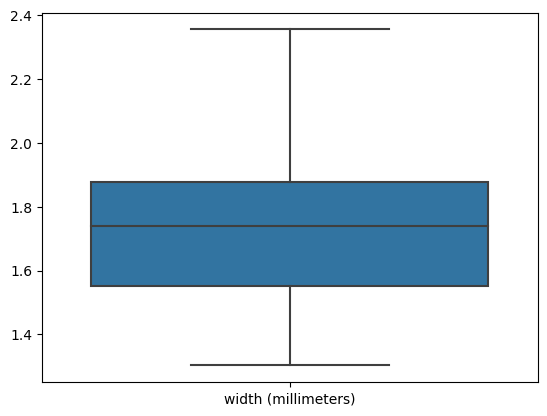

In [1733]:
# Con lo hecho, ya no quedarían valores atípicos
ax = sns.boxplot(df_practice['width (millimeters)'])
ax.set_xticklabels(['width (millimeters)'])
plt.show()


## depth (millimeters)

In [1734]:
df_practice['depth (millimeters)'].unique()


array([ 2.68,  4.04,  3.54,  4.12,  2.82,  3.19,  4.76,  2.72,  2.75,
        2.56,  3.39,  2.67,  3.21,  3.58,  4.34,  3.56,  2.74,  3.2 ,
        2.91,  4.02,  3.36,  4.28,  2.69,  4.09,  3.17,  4.07,  2.97,
        4.15,  4.24,  3.11,  2.7 ,  3.26,  3.57,  4.14,  3.55,  5.37,
        2.83,  4.71,  3.5 ,  4.23,  4.51,  2.77,  3.23,  3.98,  2.66,
        3.59,  3.53,  3.29,  4.31,  2.93,  2.65,  3.7 ,  3.61,  2.99,
        4.05,  3.32,  3.68,  3.27,  4.85,  2.85,  4.27,  3.49,  2.64,
        3.24,  2.87,  4.06,  4.55,  2.89,  4.  ,  3.82,  4.77,  4.58,
        4.1 ,  4.26,  3.02,  2.9 ,  3.85,  3.34,  2.84,  2.76,  3.92,
        4.59,  4.93,  2.71,  4.3 ,  3.13,  3.41,  4.6 ,  3.22,  4.03,
        3.16,  3.44,  4.01,  3.3 ,  2.95,  3.83,  4.53,  4.16,  4.47,
        3.81,  3.52,  4.63,  3.18,  4.11,  4.29,  2.51,  2.94,  4.65,
        3.74,  3.71,  4.64,  5.02,  4.62,  3.48,  3.42,  3.96,  4.19,
        4.5 ,  3.  ,  3.99,  4.54,  3.51,  2.98,  2.96,  3.07,  2.6 ,
        3.66,  3.38,

In [1735]:
# Empezamos por comprobar los ceros. Hay bastantes
df_practice[df_practice['depth (millimeters)'] == 0]


,id,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price
1249,1249,0.810930,3.0,1.0,2.0,61.3,58.0,2.142416,2.130610,0.0,9.642
4401,4401,0.095310,3.0,3.0,1.0,63.0,59.0,1.871802,1.867176,0.0,8.215
8174,8174,0.009950,3.0,4.0,1.0,59.2,58.0,1.871802,1.867176,0.0,8.252
10669,10669,0.405465,1.0,3.0,0.0,64.0,61.0,1.967112,1.951608,0.0,8.462
10881,10881,0.009950,3.0,2.0,0.0,58.1,59.0,1.896119,1.887070,0.0,8.061
12992,12992,0.703098,3.0,2.0,3.0,62.7,53.0,2.081938,2.073172,0.0,9.810
19007,19007,1.029619,1.0,3.0,1.0,63.8,58.0,2.186051,2.180417,0.0,9.841
23431,23431,0.788457,3.0,2.0,2.0,61.2,59.0,2.130610,2.124654,0.0,9.756
26686,26686,0.113329,3.0,3.0,0.0,60.4,59.0,1.903599,1.897620,0.0,7.776
31910,31910,0.779325,3.0,2.0,1.0,59.4,61.0,2.138889,2.134166,0.0,9.444


### Asignación del "depth (millimeters)" a partir del "lenght", el "width" y el "depth (percentage)"

In [1736]:
# Sabemos que el "depth (percentage)" se obtiene de dividir su altura total ("depth") por el diámetro
# Como tenemos el "lenght" y el "width", el diámetro se obtendría con la media de esas dos cifras
# Por tanto, podríamos resolver esos ceros con una operación
df_practice.loc[df_practice['depth (millimeters)'] == 0, 'depth (millimeters)'] = df_practice['depth (percentage)'] / 100 * (df_practice['lenght (millimeters)']+df_practice['width (millimeters)']) / 2

df_practice[df_practice['depth (millimeters)'] == 0]


,id,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price


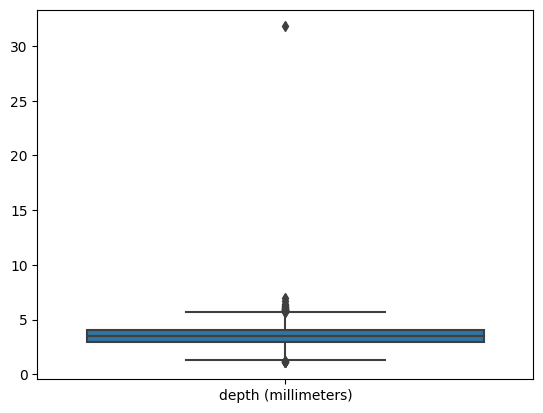

In [1737]:
# Vemos que ya no habría ceros, que los valores estarían concentrados y con varios "outliers"; uno de ellos, muy alto
ax = sns.boxplot(df_practice['depth (millimeters)'])
ax.set_xticklabels(['depth (millimeters)'])
plt.show()


### Borrado de "outliers" extremadamente altos

In [1738]:
# Podríamos liquidar ese valor tan alto con la función "remove_elements"
remove_elements(df_practice, ['depth (millimeters)'], 'bigger', 30)


### Uso del logaritmo

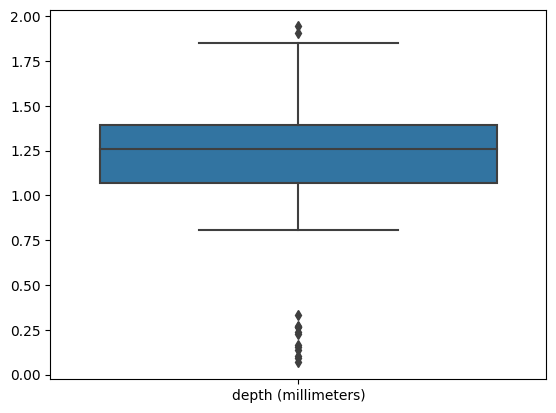

In [1739]:
# Luego, le aplicaríamos el logaritmo
apply_scalar([df_practice], 'log', list_of_columns=['depth (millimeters)'])

ax = sns.boxplot(df_practice['depth (millimeters)'])
ax.set_xticklabels(['depth (millimeters)'])
plt.show()


# Desglose por múltiples variables

In [1740]:
df_practice.head()


,id,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price
0,0,-1.203973,3.0,6.0,1.0,62.4,58.0,1.460938,1.453953,0.985817,6.353
1,1,0.009950,4.0,5.0,5.0,62.7,56.0,1.859418,1.865629,1.396245,9.183
2,2,-0.328504,4.0,4.0,3.0,61.8,59.0,1.742219,1.747459,1.264127,7.983
3,3,0.076961,2.0,3.0,1.0,63.2,57.0,1.877937,1.871802,1.415853,8.371
4,4,-1.021651,3.0,3.0,4.0,62.3,59.0,1.504077,1.515127,1.036737,6.588


In [1741]:
# La cuestión de los ceros ha quedado resuelta
df_practice.describe()


,id,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price
count,40439.000000,40439.000000,40439.000000,40439.000000,40439.000000,40439.000000,40439.000000,40439.000000,40439.000000,40439.000000,40439.000000
mean,20226.223200,-0.396497,2.907911,3.407997,3.048592,61.746829,57.451089,1.726808,1.727377,1.244329,7.783612
std,11677.449609,0.585889,1.116147,1.703587,1.646452,1.423072,2.224241,0.194131,0.192707,0.194916,1.016779
min,0.000000,-1.609438,0.000000,0.000000,0.000000,51.000000,49.000000,1.316408,1.302913,0.067659,5.787000
25%,10114.500000,-0.916291,2.000000,2.000000,2.000000,61.000000,56.000000,1.549688,1.551809,1.068153,6.851000
50%,20226.000000,-0.356675,3.000000,3.000000,3.000000,61.800000,57.000000,1.738710,1.740466,1.258461,7.779000
75%,30338.500000,0.039221,4.000000,5.000000,4.000000,62.500000,59.000000,1.877937,1.877937,1.393766,8.581000
max,40454.000000,1.472488,4.000000,6.000000,7.000000,73.600000,79.000000,2.355178,2.355178,1.943049,9.842000


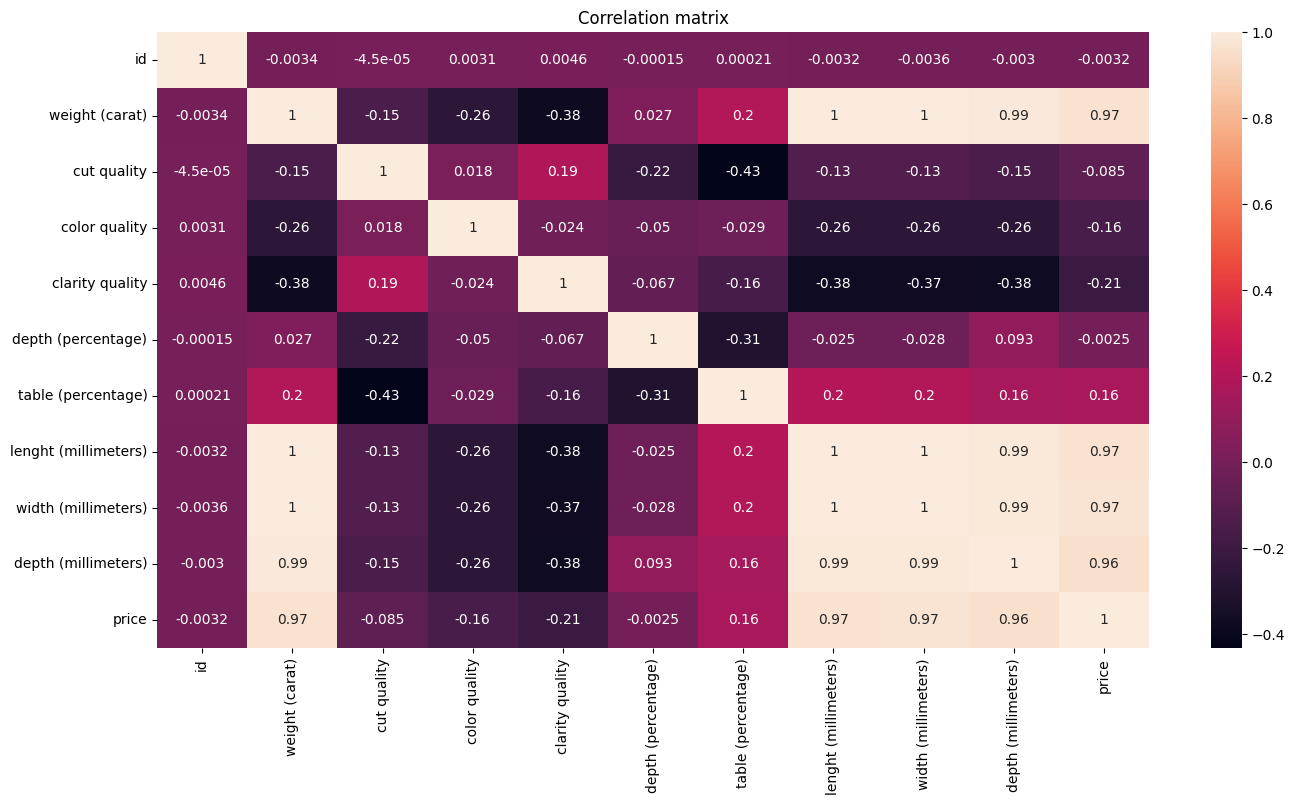

In [1742]:
# Parece que lo que más influye en el precio son el tamaño ("lenght", "width" y "depth") y el peso ("weight") del diamante
# Respecto a las medidas específicas para diamantes ("depth" y "table" en %), se supone que mejorar en una suele requerir sacrificar la otra
# Eso a se debería que la "table" (parte plana superior del diamante) es más grande en los diamantes más anchos, y no en los de mayor altura ("depth")
# Asimismo, a mayor tamaño se pierde claridad (probablemente porque, con una mayor superficie, hay más probabilidad de imperfecciones)
# Hay otra correlación negativa entre la calidad del corte y el tamaño de la tabla, quizá porque cuanto mayor es la tabla más perceptibles son los cortes
# Hay que tener en cuenta al comparar que varias variables se han tipificado
plt.rc("figure", figsize=(16, 8))

corr = df_practice.corr(numeric_only=True)
sns.heatmap(corr, annot=True)
plt.title('Correlation matrix')
plt.show()


In [1743]:
plt.rc("figure", figsize=(6.4, 4.8))


## weight (carat), lenght (millimeters), width (millimeters), depth (millimeters) & price (dollars)

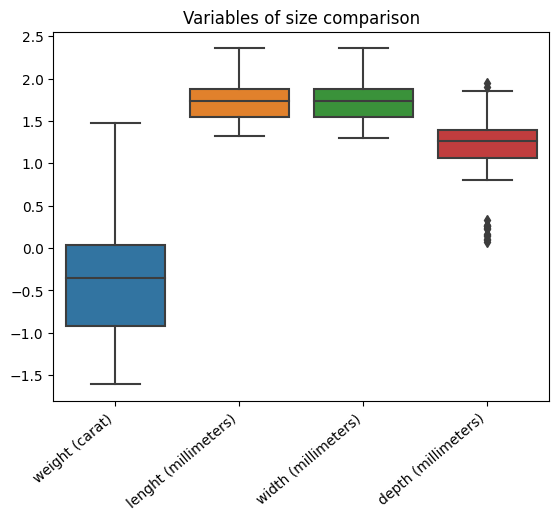

In [1744]:
# Las cuatro primeras variables del título, las que vendrían a indicar el tamaño y el peso del diamante, están altísimamente correlacionadas
# Solo "depth" tiene "outliers"

items_list = ['weight (carat)', 'lenght (millimeters)', 'width (millimeters)', 'depth (millimeters)']
df_size = df_practice[items_list]

ax = sns.boxplot(df_size)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title('Variables of size comparison')
plt.show()


### Imputación de "outliers" mediante un modelo "ridge"

In [1745]:
# Podríamos utilizar un modelo de regresión para predecir esos "outliers" e imputarlos
# Como la correlación es tan extremadamente alta que podría decirse que son prácticamente la misma variable escalada, usamos "ridge"
q3, q1 = np.percentile(df_size['depth (millimeters)'], [75, 25])
iqr = q3 - q1

y_test = df_size[(df_size['depth (millimeters)'] > q3 + 1.5*iqr) | (df_size['depth (millimeters)'] < q1 - 1.5*iqr)]['depth (millimeters)']
y_train = df_size.drop(y_test.index)['depth (millimeters)']

X_train = df_size.drop(y_test.index)[['weight (carat)', 'lenght (millimeters)', 'width (millimeters)']]
X_test = df_size[(df_size['depth (millimeters)'] > q3 + 1.5*iqr) | (df_size['depth (millimeters)'] < q1 - 1.5*iqr)][['weight (carat)', 'lenght (millimeters)', 'width (millimeters)']]

ridge = Ridge()
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

df_depth = pd.DataFrame(data={'Original depth': y_test, 'Predicted depth': y_pred})

df_depth


,Original depth,Predicted depth
1249,0.269785,1.636209
4401,0.163630,1.417624
6403,1.943049,1.855658
7978,1.905088,1.873373
8174,0.101417,1.373873
10669,0.226331,1.525884
10881,0.094416,1.361228
11619,0.067659,1.391181
12992,0.264383,1.613806
19007,0.331390,1.723095


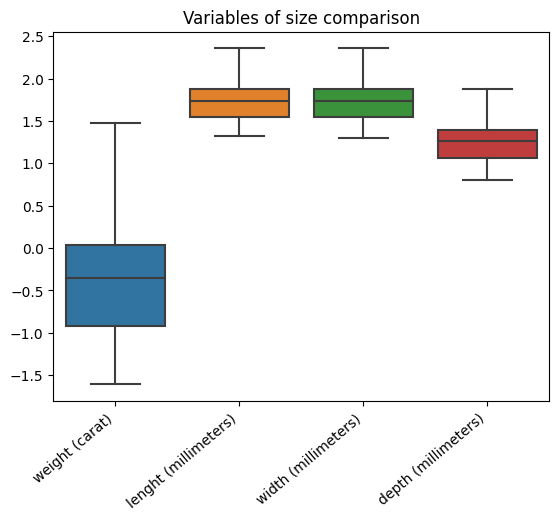

In [1746]:
# Los valores atípicos de "depth" han sido neutralizados
for index in df_depth.index:
    df_practice.loc[index, 'depth (millimeters)'] = df_depth.loc[index, 'Predicted depth']

ax = sns.boxplot(df_practice[items_list])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title('Variables of size comparison')
plt.show()


### NO EN PRUEBA: borrado de variables con altísima correlación

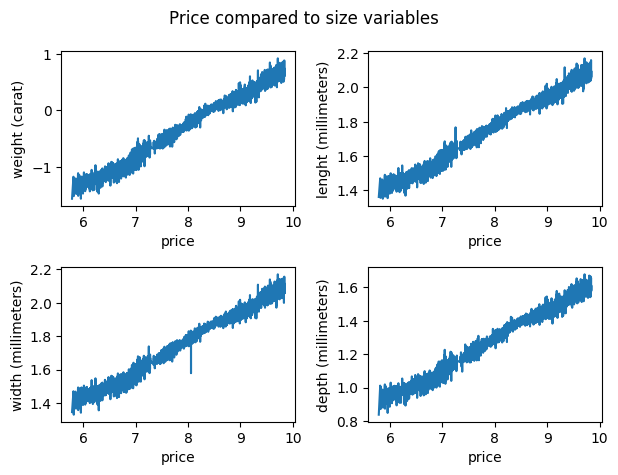

In [1747]:
# Comparamos el precio con cada una de las variables relacionadas con el tamaño
# Aplicamos "errorbar=None" para que no compute los intervalos de confianza y sea más rápido
# Detectamos que, efectivamente, suben progresivamente con el precio de un modo similar
# Por esta razón, y teniendo en cuenta la alta correlación, cabría eliminarlas
# Para el "dataframe" de práctica, las dejamos
items_list.append('price')

for index, element in enumerate(items_list[:-1], 1):
    plt.subplot(2, 2, index)
    sns.lineplot(data=df_practice, x=items_list[-1], y=element, errorbar=None)
    plt.legend('',frameon=False)
    plt.xlabel(xlabel=items_list[-1])
    plt.ylabel(ylabel=element)
plt.suptitle('Price compared to size variables')
plt.tight_layout()
plt.show()


## clarity quality, weight (carat), lenght (millimeters), width (millimeters) & depth (millimeters)

In [1748]:
# La claridad del diamante (la falta de imperfecciones) tiene una importante correlación inversa (la misma) con las variable relacionadas con el tamaño
# Como las cuatro se comportan de un modo similar, para ver la tendencia las podemos simplificar en una sola
df_practice['size'] = (df_practice['weight (carat)'] 
                        + df_practice['lenght (millimeters)'] 
                        + df_practice['width (millimeters)'] 
                        + df_practice['depth (millimeters)']) / 4

df_practice['size'].unique()


array([0.67418373, 1.28281061, 1.10632522, ..., 1.15639622, 1.27780321,
       1.41053121])

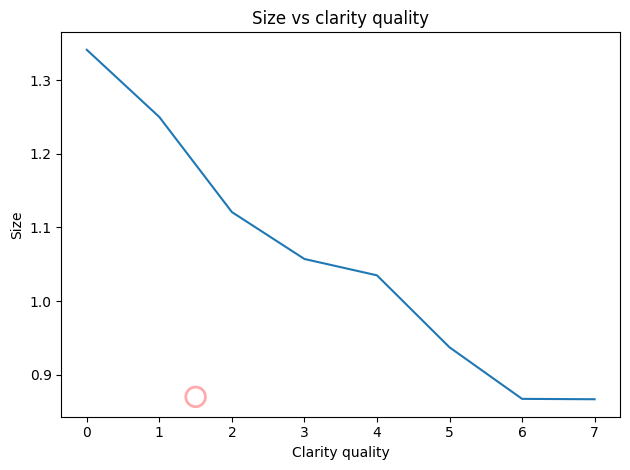

In [1749]:
# Excepto con los de mayor "clarity quality" (marcado), el tamaño es cada vez más reducido
# Para futuras pruebas del modelo, cabría considerar la posibilidad de imputar los de calidad 2.0, que son pocos, al 1.5, con tal de que la tendencia se mantenga
fig, ax = plt.subplots()
ax.scatter(1.5, 0.87, s=200, edgecolor='#ff575a', lw=2, facecolor='none', alpha=0.5, zorder=1)
sns.lineplot(y=df_practice['size'], x=df_practice['clarity quality'], errorbar=None)
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel(ylabel='Size')
plt.xlabel(xlabel='Clarity quality')
plt.title('Size vs clarity quality')
plt.tight_layout()
plt.show()


In [1750]:
df_practice = df_practice.drop(columns='size')


## table (percentage) & depth (percentage)

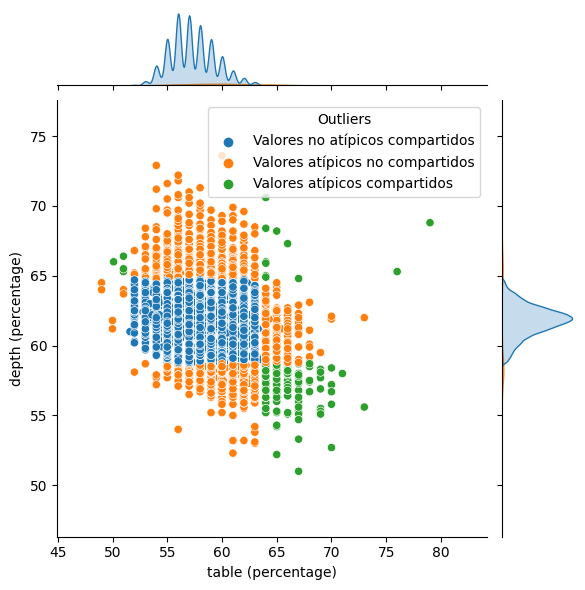

In [1751]:
# La correlación más relevante de "table" es su correlación inversa con "depth (percentage)"
# Por tanto, para investigar sus valores atípicos las estudiamos a la vez
df_practice['Outliers'] = 'Valores no atípicos compartidos'

q3_table, q1_table = np.percentile(df_practice['table (percentage)'], [75, 25])
iqr_table = q3_table - q1_table
df_practice.loc[((df_practice['table (percentage)'] > q3_table + 1.5*iqr_table) | (df_practice['table (percentage)'] < q1_table - 1.5*iqr_table)), 'Outliers'] = 'Valores atípicos no compartidos'

q3_depth, q1_depth = np.percentile(df_practice['depth (percentage)'], [75, 25])
iqr_depth = q3_depth - q1_depth
df_practice.loc[((df_practice['depth (percentage)'] > q3_depth + 1.5*iqr_depth) | (df_practice['depth (percentage)'] < q1_depth - 1.5*iqr_depth)), 'Outliers'] = 'Valores atípicos no compartidos'

df_practice.loc[((df_practice['table (percentage)'] > q3_table + 1.5*iqr_table) | (df_practice['table (percentage)'] < q1_table - 1.5*iqr_table))
                & ((df_practice['depth (percentage)'] > q3_depth + 1.5*iqr_depth) | (df_practice['depth (percentage)'] < q1_depth - 1.5*iqr_depth)), 'Outliers'] = 'Valores atípicos compartidos'

sns.jointplot(data=df_practice, x='table (percentage)', y='depth (percentage)', hue='Outliers')
plt.show()


### Borrado de "outliers" moderadamente altos

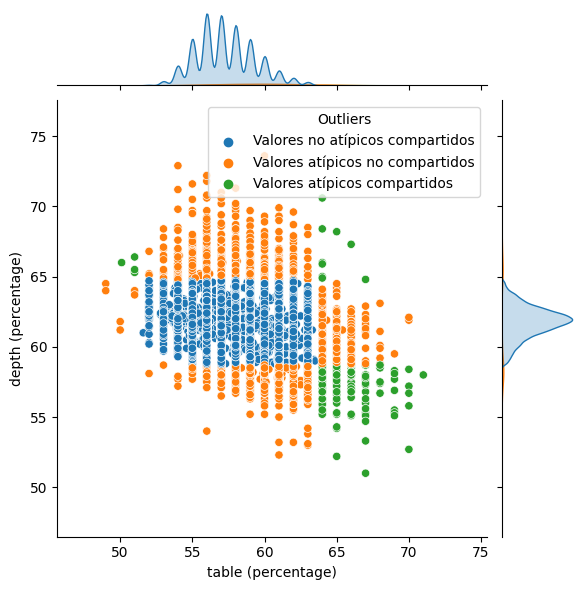

In [1752]:
# Eliminamos esos cuatro valores que están muy alejados del resto del conjunto y repetimos la gráfica
remove_elements(df_practice, ['table (percentage)'], 'bigger', 72)

sns.jointplot(data=df_practice, x='table (percentage)', y='depth (percentage)', hue='Outliers')
plt.show()


In [1753]:
# Vemos que comparten algunos "outliers". Se trata de:
# a) los diamantes con mayor tabla y mayor profundidad (algunos);
# b) los diamantes con mayor tabla y menor profundidad (pocos);
# y c) los diamantes con menor tabla y mayor profundidad (muchos)
print(f"""Nº valores atípicos compartidos: {len(df_practice[df_practice['Outliers'] == 'Valores atípicos compartidos'])}
Nº valores atípicos no compartidos: {len(df_practice[df_practice['Outliers'] == 'Valores atípicos no compartidos'])}
Nº valores no atípicos compartidos: {len(df_practice[df_practice['Outliers'] == 'Valores no atípicos compartidos'])}""")


Nº valores atípicos compartidos: 165
Nº valores atípicos no compartidos: 2009
Nº valores no atípicos compartidos: 38261


### Imputación a valores máximos y mínimos del "boxplot"

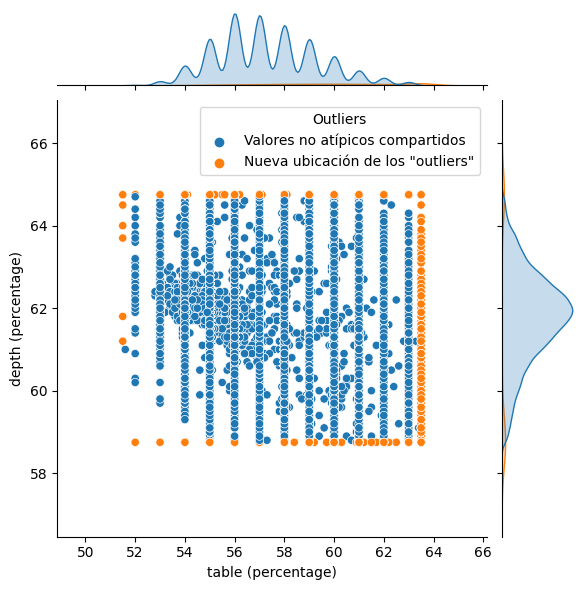

In [1754]:
# Con esa información, deducimos que la correlación negativa (-0.3) se debe al peso de los "outliers" de mayor tabla y menor profundidad, que son más numerosos
# Esa correlación es especialmente importante porque es la única lo bastante alta como para vincular las dos variables, si el modelo acaba trabajando con una de ellas
# Con tal de preservar esa correlación, podríamos imputar los valores atípicos a los máximos y mínimos de los no atípicos
impute_boxplot_min_max(df_practice, ['depth (percentage)', 'table (percentage)'], min=True, max=True)

df_practice.loc[df_practice['Outliers'] == 'Valores atípicos compartidos', 'Outliers'] = 'Valores atípicos no compartidos'
df_practice.loc[df_practice['Outliers'] == 'Valores atípicos no compartidos', 'Outliers'] = 'Nueva ubicación de los "outliers"'

sns.jointplot(data=df_practice, x='table (percentage)', y='depth (percentage)', hue='Outliers')
plt.show()


-0.3021718169794219


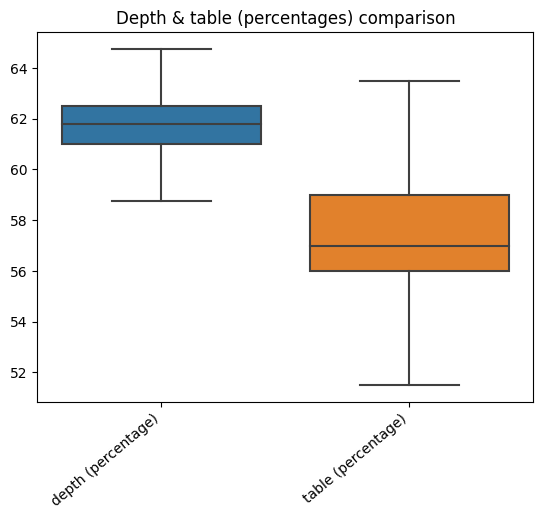

In [1755]:
# La correlación inversa se mantendría en la misma cifra y ya no habría valores atípicos
df_practice = df_practice.drop(columns='Outliers')

print(df_practice['depth (percentage)'].corr(df_practice['table (percentage)']))

ax = sns.boxplot(df_practice[['depth (percentage)', 'table (percentage)']])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title('Depth & table (percentages) comparison')
plt.show()


### Estandarización

In [1756]:
# Finalmente, aplicaríamos una estandarización a todos los "dataframes", pues estas dos columnas son muy altas
df_practice.head()


,id,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price
0,0,-1.203973,3.0,6.0,1.0,62.4,58.0,1.460938,1.453953,0.985817,6.353
1,1,0.009950,4.0,5.0,5.0,62.7,56.0,1.859418,1.865629,1.396245,9.183
2,2,-0.328504,4.0,4.0,3.0,61.8,59.0,1.742219,1.747459,1.264127,7.983
3,3,0.076961,2.0,3.0,1.0,63.2,57.0,1.877937,1.871802,1.415853,8.371
4,4,-1.021651,3.0,3.0,4.0,62.3,59.0,1.504077,1.515127,1.036737,6.588


In [1757]:
# Para el caso, solo lo hacemos con la de práctica
apply_scalar([df_practice], 'standard')

df_practice.head()


,id,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price
0,-1.732024,-1.378141,0.082273,1.521521,-1.244268,0.513804,0.262972,-1.369495,-1.418832,-1.333652,-1.406957
1,-1.731938,0.693723,0.978480,0.934523,1.185177,0.749789,-0.663848,0.683070,0.717382,0.780548,1.376240
2,-1.731852,0.116066,0.978480,0.347524,-0.029546,0.041834,0.726382,0.079380,0.104190,0.099981,0.196086
3,-1.731767,0.808093,-0.813933,-0.239474,-1.244268,1.143098,-0.200438,0.778462,0.749413,0.881556,0.577669
4,-1.731681,-1.066963,0.082273,-0.239474,0.577816,0.435142,0.726382,-1.147284,-1.101395,-1.071352,-1.175844


## cut quality & table (percentage)

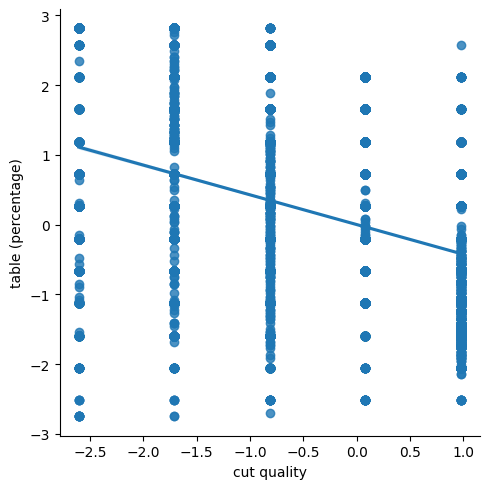

In [1759]:
# Las variables "cut quality" y "table (percentage)", que es el tamaño de la parte plana en relación con su diámetro, tienen una alta correlación inversa
# Notamos que los valores de "table (percentage)" parecen concentrarse en un punto a medida que aumenta la calidad hasta desplazarse finalmente hacia valores negativos con los mejor cortados
# Con lo visto en el análisis univariante de "cut quality" y en la gráfica, hacemos esta suposición:
# que haya pocos valores de calidad menor influye en que la concentración de los números más altos sea superior, lo que hace caer la correlación
sns.lmplot(data=df_practice, x='cut quality', y='table (percentage)')
plt.show()


In [1762]:
# Queremos fabricar más valores de "table (percentage)"" que tengan -1.0 de "cut quality" para comprobar si esa suposición es cierta
# Para ello, como no queremos que el resultado se aleje mucho la predicción de lo que ya existe y disponemos de pocos datos, iteraremos con un modelo de k vecinos
# Para asegurarnos, procuraremos que el número de valores resultantes se aceque a los 20000 que tiene el corte de mayor calidad
lower_cut = df_practice[df_practice['cut quality'] == -2.606346777168544]

new_cut = list(df_practice['cut quality'])
new_table = list(df_practice['table (percentage)'])
for _ in range(40):
    X_train, X_test, y_train, y_test = train_test_split(lower_cut.drop(columns='table (percentage)'), lower_cut['table (percentage)'], train_size=0.6, random_state=random.randint(1, 10000))
    vecinos = KNeighborsRegressor()
    vecinos.fit(X_train, y_train)
    y_pred = vecinos.predict(X_test).tolist()
    new_cut += [-2.606346777168544] * len(y_pred)
    new_table += y_pred
cut_table_comparison = pd.DataFrame({'cut quality': new_cut, 'table (percentage)': new_table})

print(f"Nº de valores -1.0 originales: {len(df_practice[df_practice['cut quality'] == -2.606346777168544])}")
print(f"Nº de valores -1.0 tras la fabricación: {len(cut_table_comparison[cut_table_comparison['cut quality'] == -2.606346777168544])}")


Nº de valores -1.0 originales: 1193
Nº de valores -1.0 tras la fabricación: 20313


### NO EN PRUEBA: aumento de valores menores de "cut quality"

                    cut quality  table (percentage)
cut quality            1.000000           -0.390223
table (percentage)    -0.390223            1.000000


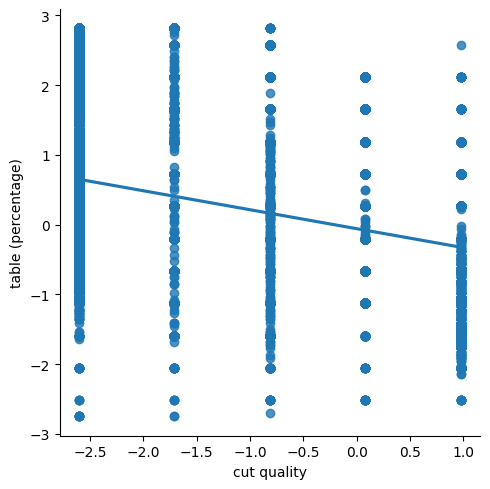

In [1763]:
# Hemos creado muchos valores artificialmente, y, sin embargo, no hay grandes cambios
# La correlación y la recta de regresión solo cambian ligeramente
# Como no es un cambio muy grande, no lo aplicamos en la práctica
print(cut_table_comparison.corr())

sns.lmplot(data=cut_table_comparison, x='cut quality', y='table (percentage)')
plt.show()


# Observaciones finales

In [1766]:
# Los números han quedado pequeños; ninguna columna tiene valores excesivamente altos (todos están alrededor del 0)
df_practice.head()


,id,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price
0,-1.732024,-1.378141,0.082273,1.521521,-1.244268,0.513804,0.262972,-1.369495,-1.418832,-1.333652,-1.406957
1,-1.731938,0.693723,0.978480,0.934523,1.185177,0.749789,-0.663848,0.683070,0.717382,0.780548,1.376240
2,-1.731852,0.116066,0.978480,0.347524,-0.029546,0.041834,0.726382,0.079380,0.104190,0.099981,0.196086
3,-1.731767,0.808093,-0.813933,-0.239474,-1.244268,1.143098,-0.200438,0.778462,0.749413,0.881556,0.577669
4,-1.731681,-1.066963,0.082273,-0.239474,0.577816,0.435142,0.726382,-1.147284,-1.101395,-1.071352,-1.175844


In [1767]:
# Se han borrado algunas filas respecto a las iniciales
df_practice.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 40435 entries, 0 to 40454
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    40435 non-null  float64
 1   weight (carat)        40435 non-null  float64
 2   cut quality           40435 non-null  float64
 3   color quality         40435 non-null  float64
 4   clarity quality       40435 non-null  float64
 5   depth (percentage)    40435 non-null  float64
 6   table (percentage)    40435 non-null  float64
 7   lenght (millimeters)  40435 non-null  float64
 8   width (millimeters)   40435 non-null  float64
 9   depth (millimeters)   40435 non-null  float64
 10  price                 40435 non-null  float64
dtypes: float64(11)
memory usage: 3.7 MB


In [1768]:
# Todas las columnas son numéricas y no hay ceros en las variables relacionadas con el tamaño
df_practice.describe()


,id,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price
count,4.043500e+04,4.043500e+04,4.043500e+04,4.043500e+04,4.043500e+04,4.043500e+04,4.043500e+04,4.043500e+04,4.043500e+04,4.043500e+04,4.043500e+04
mean,-1.349566e-16,2.178986e-17,2.266848e-17,-6.659965e-17,1.216015e-16,9.281162e-15,3.016138e-15,-6.326088e-17,-1.325316e-15,-3.915146e-16,6.979784e-16
std,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00
min,-1.732024e+00,-2.070168e+00,-2.606347e+00,-2.000468e+00,-1.851629e+00,-2.357349e+00,-2.749194e+00,-2.113966e+00,-2.202589e+00,-2.257474e+00,-1.963597e+00
25%,-8.659589e-01,-8.871393e-01,-8.139334e-01,-8.264719e-01,-6.369069e-01,-5.874601e-01,-6.638483e-01,-9.123454e-01,-9.110522e-01,-9.095202e-01,-9.171930e-01
50%,2.025918e-05,6.798487e-02,8.227326e-02,-2.394738e-01,-2.954568e-02,4.183360e-02,-2.004382e-01,6.130589e-02,6.790252e-02,7.079560e-02,-3.556880e-03
75%,8.659138e-01,7.436797e-01,9.784799e-01,9.345226e-01,5.778156e-01,5.924656e-01,7.263820e-01,7.784617e-01,7.812479e-01,7.677819e-01,7.841962e-01
max,1.732236e+00,3.189908e+00,9.784799e-01,1.521521e+00,2.399899e+00,2.362354e+00,2.811728e+00,3.236720e+00,3.257678e+00,3.238336e+00,2.024342e+00


In [1769]:
# No hay duplicados
df_practice[df_practice.duplicated()]


,id,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price


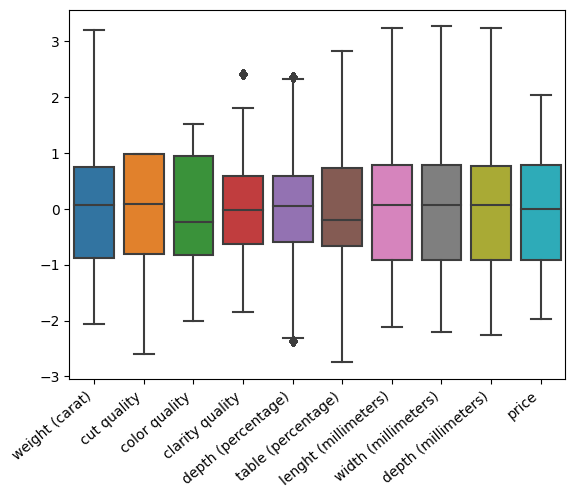

In [1772]:
# No hay valores atípicos salvo en "clarity quality" y "depth (percentage)"
ax = sns.boxplot(df_practice.drop(columns='id'))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()


### Imputación de "outliers" tras escalado

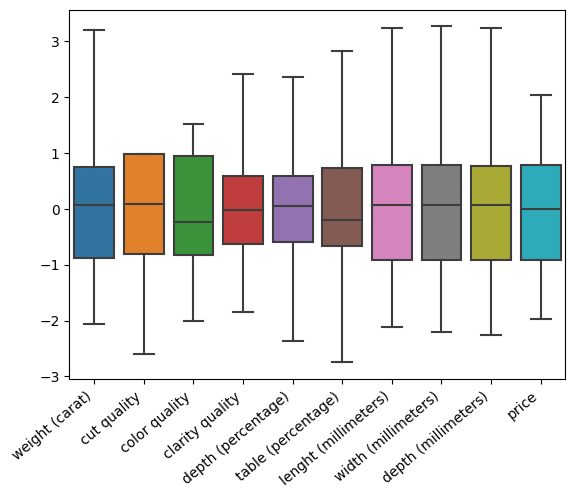

In [1774]:
# Están muy cerca del máximo (probablemente han salido al hacer el escalado) así que los imputamos ahí
impute_boxplot_min_max(df_practice, ['clarity quality', 'depth (percentage)'])

ax = sns.boxplot(df_practice.drop(columns='id'))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()


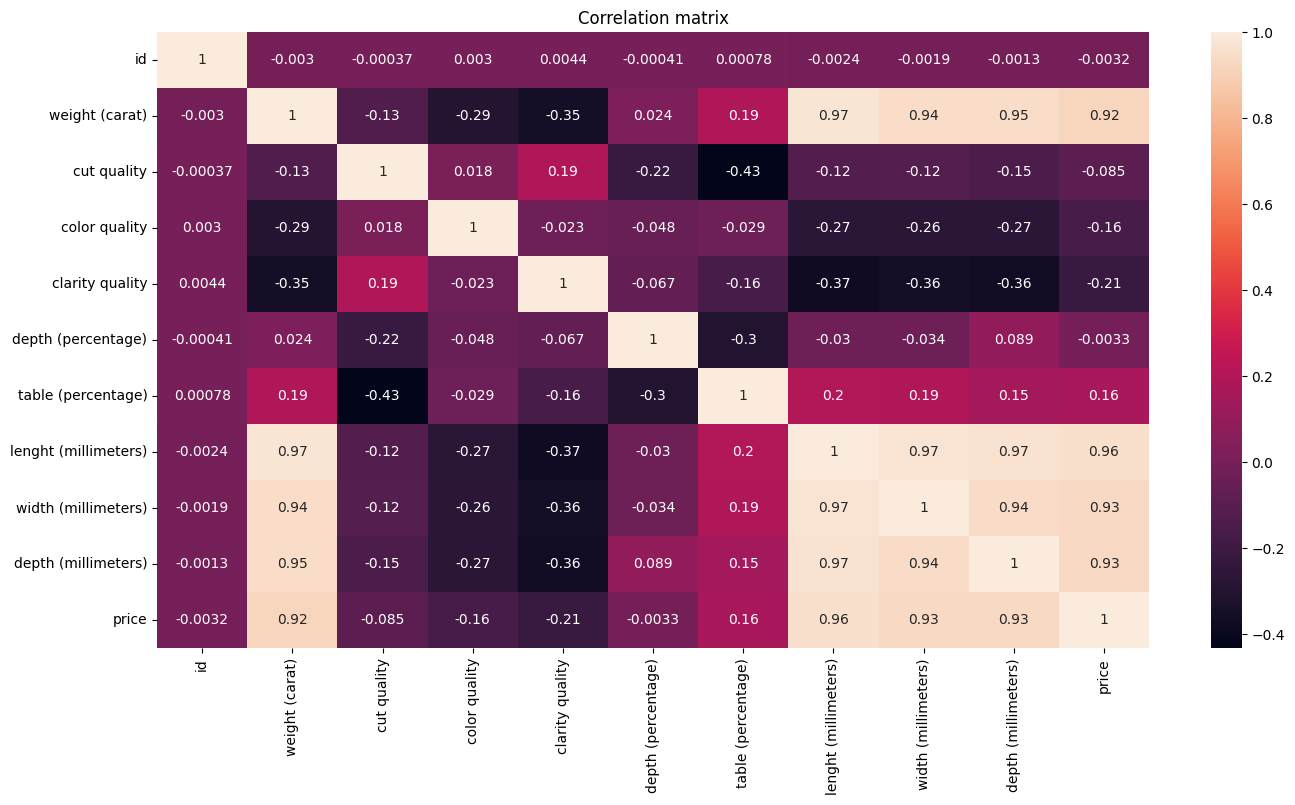

In [1775]:
# La correlación ha cambiado un poco (por ejemplo, algunos valores se han convertido en 1) debido al escalado de los datos
# La tendencia general es similar y se han incorporado las variables que eran categóricas
plt.rc("figure", figsize=(16, 8))

corr = df_diamonds[0].corr(numeric_only=True)
sns.heatmap(corr, annot=True)
plt.title('Correlation matrix')
plt.show()


In [1776]:
plt.rc("figure", figsize=(6.4, 4.8))


# Exportación

In [1779]:
df_diamonds[0].head()


,id,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price
0,0,0.30,3.0,6.0,1.0,62.4,58.0,4.31,4.28,2.68,6.353
1,1,1.01,4.0,5.0,5.0,62.7,56.0,6.42,6.46,4.04,9.183
2,2,0.72,4.0,4.0,3.0,61.8,59.0,5.71,5.74,3.54,7.983
3,3,1.08,2.0,3.0,1.0,63.2,57.0,6.54,6.50,4.12,8.371
4,4,0.36,3.0,3.0,4.0,62.3,59.0,4.50,4.55,2.82,6.588


In [1780]:
df_diamonds[1].head()


,id,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters)
0,0,0.32,4.0,1.0,2.0,60.5,58.0,4.43,4.49,2.70
1,1,1.24,3.0,1.0,2.0,62.9,60.0,6.80,6.74,4.26
2,2,1.66,3.0,6.0,2.0,62.0,59.0,7.55,7.60,4.70
3,3,0.75,3.0,6.0,1.0,60.6,56.0,5.94,5.90,3.59
4,4,1.50,0.0,5.0,1.0,64.8,55.0,7.26,7.15,4.67


In [ ]:
# El "dataframe" está preparado para el modelaje. Lo exportamos
df_diamonds[0].to_csv(r'..\data\processed\diamonds_train_1.csv', index=False)
df_diamonds[1].to_csv(r'..\data\processed\diamonds_test_1.csv', index=False)
